In [1]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu

import experiment
import fluffi

%matplotlib inline

# Constants
LOCATIONS = [fluffi.LOCATION_FMT.format(n) for n in range(experiment.N_MIN, experiment.N_MAX + 1)]
RUN1_DIR = os.path.join(experiment.EXP_BASE_DIR, "run1/")
RUN2_DIR = os.path.join(experiment.EXP_BASE_DIR, "run2/")
RUN1_NAMES = {"1021-5": "fluffi+no_ps", "1021-6": "fluffi+ps", "1021-7": "rr+no_ps", "1021-8": "rr+ps"}
RUN2_NAMES = {"1021-5": "aflfast+no_ps", "1021-6": "aflfast+ps", "1021-7": "aflfast+no_ps", "1021-8": "aflfast+ps"}
EXPERIMENTS = ["fluffi+no_ps", "fluffi+ps", "rr+no_ps", "rr+ps", "aflfast+no_ps", "aflfast+ps"]


In [2]:
exps = []

# Iterate over locations
for location in LOCATIONS:
    location1_dir = os.path.join(RUN1_DIR, location)
    location2_dir = os.path.join(RUN2_DIR, location)

    # Iterate over benchmarks
    for benchmark in experiment.BENCHMARKS:
        benchmark1_dir = os.path.join(location1_dir, benchmark)
        benchmark2_dir = os.path.join(location2_dir, benchmark)

        # Get the trials for run1
        trial = 1
        for filename in os.listdir(benchmark1_dir):
            if not filename.endswith(".parquet"):
                continue
            parquet_path = os.path.join(benchmark1_dir, filename)

            # Read from parquet
            df = pd.read_parquet(parquet_path)
            df["experiment"] = RUN1_NAMES[location]
            df["benchmark"] = benchmark
            df["trial"] = trial
            exps.append(df)
            trial += 1

        # Get the trials for run2
        trial = 1
        for filename in os.listdir(benchmark2_dir):
            if not filename.endswith(".parquet"):
                continue
            parquet_path = os.path.join(benchmark2_dir, filename)

            # Read from parquet
            df = pd.read_parquet(parquet_path)
            df["experiment"] = RUN2_NAMES[location]
            df["benchmark"] = benchmark
            df["trial"] = trial + 10 if location in ["1021-7", "1021-8"] else trial
            exps.append(df)
            trial += 1

# Create one DataFrame
df = pd.concat(exps, ignore_index=True)
df_max = df.loc[df.groupby(["experiment", "benchmark", "trial"])["cpu_time"].idxmax()]


In [60]:
y_key = "covered_blocks"
wins = {}
for exp in EXPERIMENTS:
    wins[exp] = 0

for benchmark in experiment.BENCHMARKS:
    # print(f"\n\n{benchmark}")
    df_benchmark = df_max.loc[df_max["benchmark"] == benchmark]
    for exp1, exp2 in itertools.combinations(EXPERIMENTS, 2):
        x = df_benchmark.loc[df_benchmark["experiment"] == exp1][y_key]
        y = df_benchmark.loc[df_benchmark["experiment"] == exp2][y_key]
        # print(f"{exp1} - {x.mean()}, {exp2} - {y.mean()}")
        # print(mannwhitneyu(x, y))
        try:
            _, p = mannwhitneyu(x, y)
        except:
            continue
        if p < 0.05:
            if x.mean() > y.mean():
                # print(f"{exp1} {x.mean()} over {exp2} {y.mean()}")
                wins[exp1] += 1
            else:
                # print(f"{exp2} {y.mean()} over {exp1} {x.mean()}")
                wins[exp2] += 1

print(dict(sorted(wins.items(), key=lambda item: item[1], reverse=True)))


{'aflfast+ps': 27, 'aflfast+no_ps': 26, 'fluffi+no_ps': 20, 'fluffi+ps': 16, 'rr+no_ps': 11, 'rr+ps': 4}


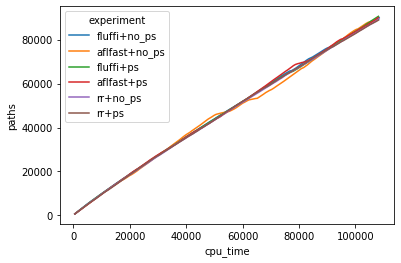

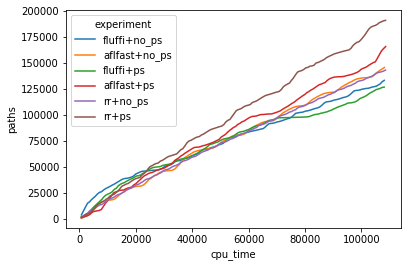

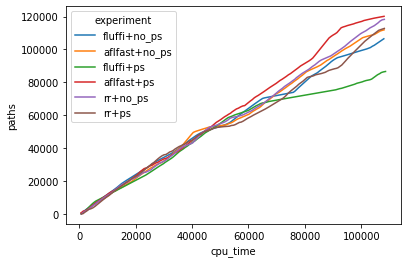

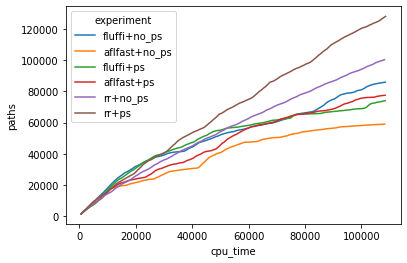

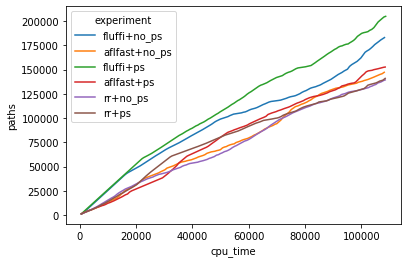

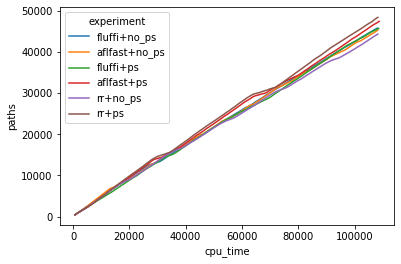

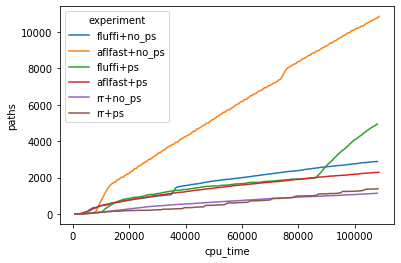

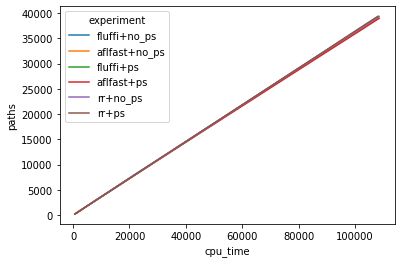

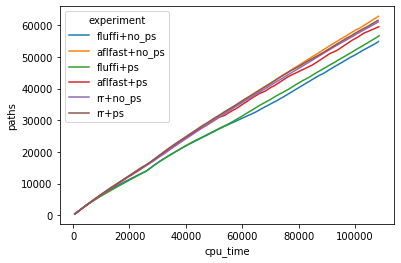

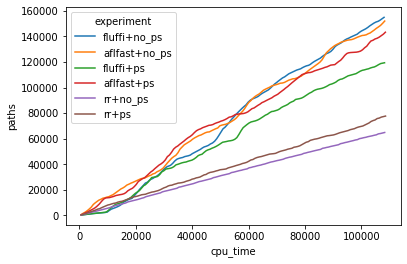

In [57]:
for benchmark in experiment.BENCHMARKS:
    df_benchmark = df.loc[(df["benchmark"] == benchmark) & (df["trial"] == 2)]
    plt.figure()
    sns.lineplot(y="paths", x="cpu_time", hue="experiment", data=df_benchmark, estimator=np.median, ci=95)

In [52]:
y_key = "paths"
sum_coverage = {}
sum_ranks = {}
for exp in EXPERIMENTS:
    sum_coverage[exp] = 0
    sum_ranks[exp] = 0

for benchmark in experiment.BENCHMARKS:
    exp_coverage = {}
    df_benchmark = df_max[df_max["benchmark"] == benchmark]
    max_coverage = df_benchmark[y_key].max()
    for exp in EXPERIMENTS:
        median_coverage = df_benchmark[df_benchmark["experiment"] == exp][y_key].median()
        sum_coverage[exp] += 0 if max_coverage == 0 else (median_coverage / max_coverage) * 100.0
        exp_coverage[exp] = median_coverage
    for rank, key in enumerate(sorted(exp_coverage, key=exp_coverage.get, reverse=True), 1):
        sum_ranks[key] += rank

coverage_score = {}
rank_score = {}
for exp in EXPERIMENTS:
    coverage_score[exp] = sum_coverage[exp] / len(experiment.BENCHMARKS)
    rank_score[exp] = sum_ranks[exp] / len(experiment.BENCHMARKS)

print(dict(sorted(coverage_score.items(), key=lambda item: item[1], reverse=True)))
print(dict(sorted(rank_score.items(), key=lambda item: item[1])))

{'aflfast+ps': 79.90817141551517, 'rr+ps': 79.59317195951805, 'fluffi+no_ps': 75.69802987083901, 'aflfast+no_ps': 75.01182469372877, 'fluffi+ps': 74.20840740603602, 'rr+no_ps': 73.34104059858713}
{'aflfast+ps': 2.3, 'rr+ps': 2.8, 'fluffi+ps': 3.7, 'fluffi+no_ps': 3.8, 'aflfast+no_ps': 4.0, 'rr+no_ps': 4.4}
